In [1]:
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# 1. Cargar los datos
df = pd.read_csv("caso5_marketing_conversion.csv")

In [3]:
df.head()

,duracion_video_seg,plataforma,segmento,likes,comentarios,conversion
0,46,Facebook,Adulto,524,91,0
1,90,Facebook,Senior,36,21,0
2,55,Facebook,Senior,588,198,0
3,77,Facebook,Senior,234,182,0
4,64,Facebook,Joven,970,161,0


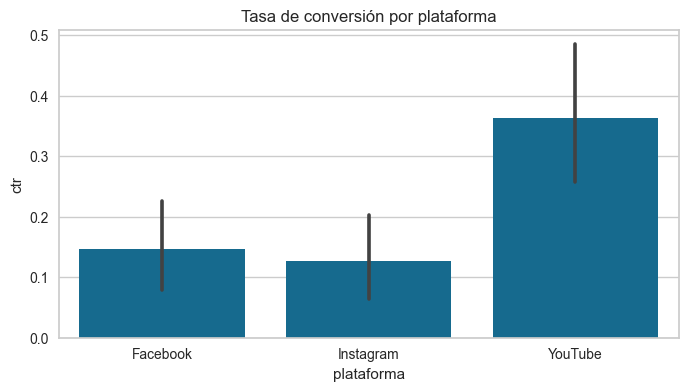

In [4]:
# 2. Análisis exploratorio: CTR por plataforma
df['ctr'] = df['conversion']
plt.figure(figsize=(8,4))
sns.barplot(data=df, x='plataforma', y='ctr')
plt.title("Tasa de conversión por plataforma")
plt.show()

In [4]:
# 3. Feature engineering: engagement combinado
df['engagement'] = np.sqrt(df['likes'] * 0.7 + df['comentarios'] * 1.5)

In [5]:
# Binning inteligente: duración en rangos
df['duracion_categoria'] = pd.cut(df['duracion_video_seg'],
                                  bins=[0, 30, 60, 120],
                                  labels=['Corto', 'Medio', 'Largo'])

In [6]:
# Interacción de plataforma con segmento
df['canal_segmento'] = df['plataforma'] + "_" + df['segmento']

In [9]:
# 4. PyCaret: setup con técnicas avanzadas
clf = setup(data=df,
            target='conversion',
            session_id=2025,
            categorical_features=['plataforma', 'segmento', 'duracion_categoria', 'canal_segmento'],
            ignore_features=['ctr', 'duracion_video_seg'],  # lo reemplazamos por la versión binned
            normalize=True,
            feature_selection=True,
            remove_multicollinearity=True,
            transformation=True,
            transformation_method='yeo-johnson',
            )

[LightGBM] [Info] Number of positive: 32, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 154, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207792 -> initscore=-1.338285
[LightGBM] [Info] Start training from score -1.338285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Description,Value
0,Session id,2025
1,Target,conversion
2,Target type,Binary
3,Original data shape,"(220, 9)"
4,Transformed data shape,"(220, 2)"
5,Transformed train set shape,"(154, 2)"
6,Transformed test set shape,"(66, 2)"
7,Ignore features,2
8,Numeric features,3
9,Categorical features,4


In [11]:
# 5. Comparar modelos por F1 (conversion es evento raro)
best = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7533,0.6334,0.3500,0.3250,0.3333,0.1882,0.1877,0.0550
rf,Random Forest Classifier,0.7533,0.7136,0.3500,0.3250,0.3333,0.1882,0.1877,0.0910
ada,Ada Boost Classifier,0.7908,0.6650,0.2750,0.4167,0.3167,0.2175,0.2287,0.0900
gbc,Gradient Boosting Classifier,0.7533,0.6937,0.3167,0.2917,0.3000,0.1604,0.1576,0.0850
et,Extra Trees Classifier,0.7338,0.6340,0.2833,0.2917,0.2857,0.1283,0.1257,0.0870
knn,K Neighbors Classifier,0.7525,0.6390,0.1500,0.2750,0.1852,0.0698,0.0760,0.0640
svm,SVM - Linear Kernel,0.7225,0.5496,0.1583,0.0952,0.1171,0.0206,0.0236,0.0550
lightgbm,Light Gradient Boosting Machine,0.7663,0.6420,0.0667,0.1500,0.0900,0.0238,0.0287,0.0720
lr,Logistic Regression,0.7925,0.6506,0.0000,0.0000,0.0000,0.0000,0.0000,0.0570
nb,Naive Bayes,0.7925,0.6506,0.0000,0.0000,0.0000,0.0000,0.0000,0.0590


In [13]:
ada= create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8750,0.6354,0.5000,1.0000,0.6667,0.6000,0.6547
1,0.7500,0.7812,0.2500,0.5000,0.3333,0.2000,0.2182
2,0.8750,0.8974,0.6667,0.6667,0.6667,0.5897,0.5897
3,0.8750,0.6410,0.3333,1.0000,0.5000,0.4483,0.5375
4,0.8667,0.8889,0.6667,0.6667,0.6667,0.5833,0.5833
5,0.7333,0.5139,0.3333,0.3333,0.3333,0.1667,0.1667
6,0.8000,0.8750,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7333,0.3056,0.0000,0.0000,0.0000,-0.1111,-0.1336
8,0.7333,0.5278,0.0000,0.0000,0.0000,-0.1111,-0.1336


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.6771,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7500,0.8125,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8750,0.7692,0.3333,1.0000,0.5000,0.4483,0.5375
3,0.8750,0.8205,0.3333,1.0000,0.5000,0.4483,0.5375
4,0.8667,0.8889,0.3333,1.0000,0.5000,0.4444,0.5345
5,0.8000,0.6944,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8000,0.6806,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8000,0.3750,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8000,0.6250,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


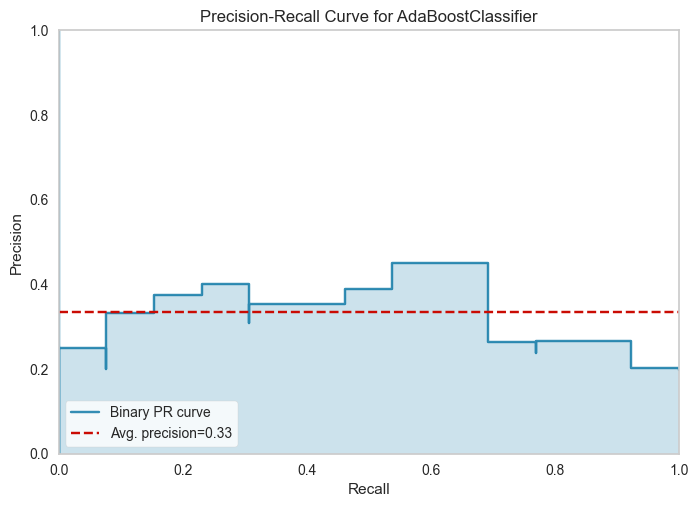

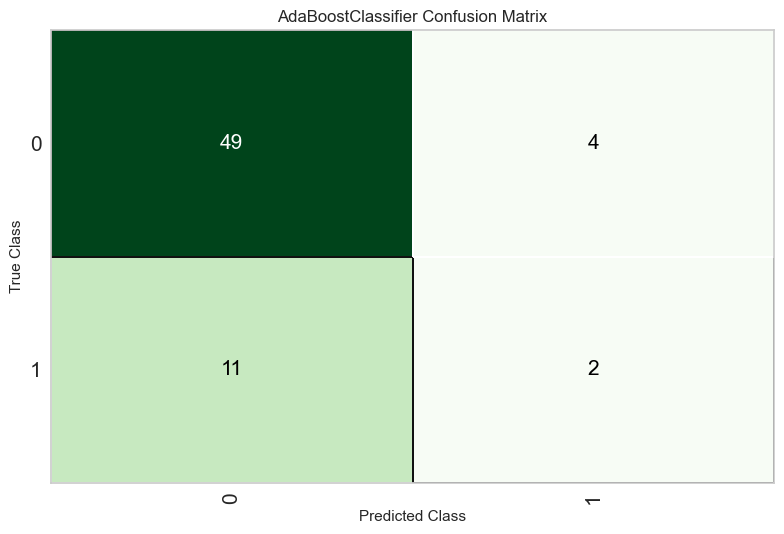

In [15]:
# 6. Ajuste fino y visualización
final = tune_model(ada, optimize='Prec.')
plot_model(final, plot='pr')  # Precision-Recall
plot_model(final, plot='confusion_matrix')

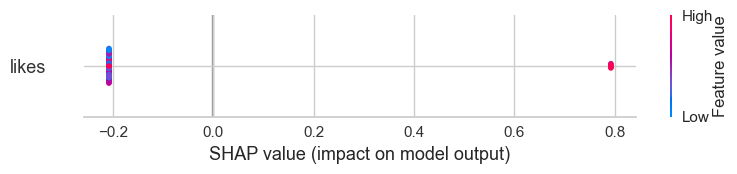

In [13]:
# 7. Interpretabilidad con SHAP
interpret_model(final)

In [18]:
# 8. Simular una campaña antes de lanzarla
nueva_campaña = pd.DataFrame({
    'plataforma': ['YouTube'],
    'segmento': ['Adulto'],
    'likes': [180],
    'comentarios': [45],
    'engagement': [np.sqrt(180 * 0.7 + 45 * 1.5)],
    'duracion_categoria': ['Medio'],
    'canal_segmento': ['YouTube_Adulto']
})
resultado = predict_model(final, data=nueva_campaña)
print("Conversión esperada:", resultado[['prediction_label', 'prediction_score']])

Conversión esperada:    prediction_label  prediction_score
0                 0            0.5304


In [19]:
# 9. Exportar modelo para uso por el equipo creativo
save_model(final, 'modelo_marketing_conversion_predictor')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['likes', 'comentarios',
                                              'engagement'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['plataf...
                                                                                          num_le